# Create artifact from time series dataframe

In [ ]:
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from dvats.load import TSArtifact, infer_or_inject_freq
import pickle
import matplotlib
import matplotlib.pyplot as plt
from tsai.data.external import convert_tsf_to_dataframe
from tsai.utils import stack_pad

### Notebook config

In [ ]:
base_path = Path.home()

In [ ]:
config = AttrDict(
    
    # Name of the artifact to be created
    artifact_name = 'synthetic_online',
    
    # CSV file config ({} if this setting is not required)
    csv_config = {},
    # csv_config = AttrDict(
    #     skiprows=15, 
    #     names=['DateTime', 'F10.7'], 
    #     sep=';'
    # ),
    
    # Put here the idxs of the columns of interest ([] for all)
    data_cols = [13],
    
    # Name of the data file. Must be pickle, csv or tsf file
    data_fpath = os.path.join(base_path, 'data', 'synthetic_data', 'synthetic_online(I).csv'), 
    
    # Default date format
    date_format = '%Y-%m-%d %H:%M:%S',
    
    # Frequency offset used to set the date index (None to omit it) [Example pd.offsets.MonthEnd(0)]
    date_offset = None,
    
    # Frequency of the data (cannot be None). It can be used to force a sampling freq to data without an index
    # See offset aliases in https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
    freq = '1m',   
    
    # To create an artifact linking training and testing data (False if it doesn't)
    joining_train_test = True, 
    
    # Handle missing values technique
    missing_values_technique=None, 
    # Default value used for missing values
    missing_values_constant=None,
    
    # To normalize the data
    normalize_training = False,
    
    # Training and Testing ranges. They can be lists with values to be included 
    # (of the same type as the index) or dictionaries that include the keys 'start', 'end' and 'freq'.
    range_training = None,
    range_testing = None,
    
    # Resampling frequency
    resampling_freq = '10T', 
    
    # Starting date (in format yyyy-mm-dd)
    start_date = None, # set to None for default start date
    
    # Ratio of test set, only if range_training and range_testing are None
    test_split = 0.2,
    
    # List or int with the idx(s) of the column containing the timestamp
    time_col = 0,
    
    # Wandb config
    use_wandb = True, # Whether to use or not wandb for experiment tracking
    # Output path where the resulting TSArtifact will be stored
    wandb_artifacts_path = os.path.join('data','wandb_artifacts'),
)

### Data Extraction

The data is assumed to come as a dataframe, either as a binarized  picke file or
as a csv file. It can also come as a `.tsf` file

In [ ]:
ext = str(config.data_fpath).split('.')[-1]

if ext == 'pickle':
    df = pd.read_pickle(config.data_fpath)
    
elif ext in ['csv','txt']:
    df = pd.read_csv(config.data_fpath, **config.csv_config)
    
elif ext == 'tsf':
    data, _, _, _, _ = convert_tsf_to_dataframe(config.data_fpath)
    config.update({'start_date': data.start_timestamp[0]}, allow_val_change=True)
    date_format = config.date_format
    df = pd.DataFrame(stack_pad(data.series_value).T)
    
else:
    raise Exception('The data file path has an unsupported extension')
    
print(f'File loaded successfully')
print(df.shape)
df.head()

File loaded successfully
(28740, 14)


,Timestamp,1 hours component,2 hours component,3 hours component,4 hours component,6 hours component,8 hours component,12 hours component,Hourly component,Daily component,Weekly component,Noise,Seasonal time series,Seasonal time series w/ noise
0,2022-03-01 00:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,3.028998,0.000000,3.028998
1,2022-03-01 00:01:00,0.0,0.0,0.0,0.013088,0.0,0.026179,0.0,0.039268,0.013090,0.000312,2.299370,0.052669,2.352039
2,2022-03-01 00:02:00,0.0,0.0,0.0,0.026168,0.0,0.052354,0.0,0.078522,0.026180,0.000623,0.369983,0.105325,0.475307
3,2022-03-01 00:03:00,0.0,0.0,0.0,0.039230,0.0,0.078520,0.0,0.117749,0.039269,0.000935,-0.749925,0.157953,-0.591972
4,2022-03-01 00:04:00,0.0,0.0,0.0,0.052264,0.0,0.104672,0.0,0.156936,0.052357,0.001247,-0.408731,0.210540,-0.198191


In [ ]:
# Set the time columm (if any) as an index
if config.time_col is not None:
    
    if isinstance(config.time_col, int): 
        datetime = df.iloc[:, config.time_col]
        
    elif isinstance(config.time_col, list): 
        datetime = df.iloc[:, config.time_col].apply(lambda x: x.astype(str).str.cat(sep='-'), axis=1)
        
    index = pd.DatetimeIndex(datetime)
    if config.date_offset:
        index += config.date_offset
    
    df = df.set_index(index, drop=False)
    
df.head()

,Timestamp,1 hours component,2 hours component,3 hours component,4 hours component,6 hours component,8 hours component,12 hours component,Hourly component,Daily component,Weekly component,Noise,Seasonal time series,Seasonal time series w/ noise
Timestamp,,,,,,,,,,,,,,
2022-03-01 00:00:00,2022-03-01 00:00:00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,3.028998,0.000000,3.028998
2022-03-01 00:01:00,2022-03-01 00:01:00,0.0,0.0,0.0,0.013088,0.0,0.026179,0.0,0.039268,0.013090,0.000312,2.299370,0.052669,2.352039
2022-03-01 00:02:00,2022-03-01 00:02:00,0.0,0.0,0.0,0.026168,0.0,0.052354,0.0,0.078522,0.026180,0.000623,0.369983,0.105325,0.475307
2022-03-01 00:03:00,2022-03-01 00:03:00,0.0,0.0,0.0,0.039230,0.0,0.078520,0.0,0.117749,0.039269,0.000935,-0.749925,0.157953,-0.591972
2022-03-01 00:04:00,2022-03-01 00:04:00,0.0,0.0,0.0,0.052264,0.0,0.104672,0.0,0.156936,0.052357,0.001247,-0.408731,0.210540,-0.198191


In [ ]:
# Set dataframe frequency
df = infer_or_inject_freq(df, injected_freq=config.freq, 
                          start_date=config.start_date, format=config.date_format)
df.index.freq

<Minute>

In [ ]:
# Subset of variables
if config.data_cols:
    df = df.iloc[:, config.data_cols]

print(f'Num. variables: {len(df.columns)}')

Num. variables: 1


In [ ]:
# Replace the default missing values by np.NaN
if config.missing_values_constant:
    df.replace(config.missing_values_constant, np.nan, inplace=True)

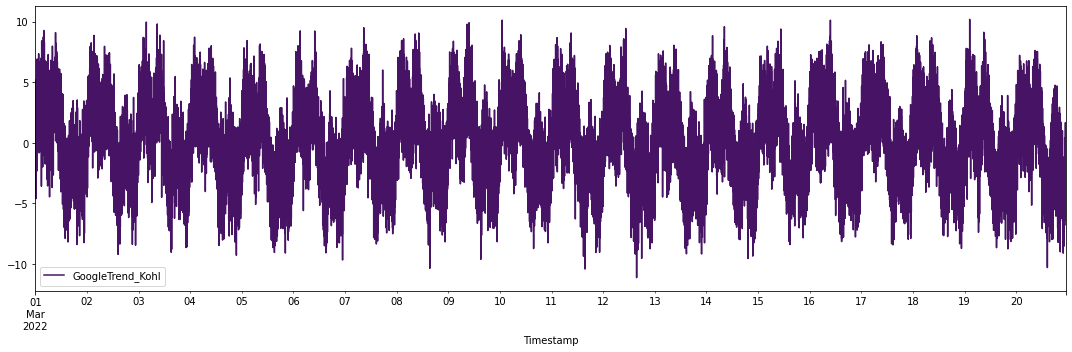

In [ ]:
# Show time series plot
fig, ax = plt.subplots(1, figsize=(15,5), )
cmap = matplotlib.cm.get_cmap('viridis')
aux_df = df.iloc[:,-1].rename('GoogleTrend_Kohl')
aux_df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
# rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
# ax.add_patch(rect)
plt.tight_layout()
plt.legend()
plt.show()

### Data Transformation

__Handle Missing Values, Resample and Normalize__

In this second part, Time Series Artifact (TSArtifact) object can be created and missing values handling techniques, resampling and normalization can be applied. This techniques should be applied on the three subsets that must be previously created: training, validation and testing.

In [ ]:
# Training data
rg = config.range_training

if isinstance(rg, list):
    rg_training = rg
    
elif isinstance(rg, dict):
    rg_training = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])
    
elif config.test_split:
    rg_training = df.index[:math.ceil(len(df) * (1-config.test_split))]

else:
    rg_training = None
    
df_training = df[df.index.isin(rg_training)] if rg_training is not None else df
training_artifact = TSArtifact.from_df(df_training, 
                                       name=config.artifact_name, 
                                       missing_values_technique=config.missing_values_technique,
                                       resampling_freq=config.resampling_freq, 
                                       normalize=config.normalize_training, 
                                       path=str(Path.home()/config.wandb_artifacts_path))
display(training_artifact.metadata)

{'TS': {'sd': '2022-03-01 00:00:00',
  'ed': '2022-03-16 23:11:00',
  'created': 'from-df',
  'n_vars': 1,
  'handle_missing_values_technique': 'None',
  'has_missing_values': 'False',
  'n_samples': 2300,
  'freq': '<10 * Minutes>',
  'vars': ['Seasonal time series w/ noise'],
  'hash': '1461384420930004535'}}

In [ ]:
# Testing data
rg = config.range_testing

if rg or config.test_split:
    
    if isinstance(rg, list):
        rg_testing = rg

    elif isinstance(rg, dict):
        rg_testing = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])

    elif config.test_split:
        rg_testing = df.index[math.ceil(len(df) * (1 - config.test_split)):]

    else:
        rg_testing = None
    
    df_testing = df[df.index.isin(rg_testing)]
    testing_artifact = TSArtifact.from_df(df_testing,
                                          name=config.artifact_name, 
                                          missing_values_technique=config.missing_values_technique,
                                          resampling_freq=config.resampling_freq, 
                                          normalize=False,
                                          path=str(Path.home()/config.wandb_artifacts_path))
    display(testing_artifact.metadata)
else:
    testing_artifact = None

{'TS': {'sd': '2022-03-16 23:12:00',
  'ed': '2022-03-20 22:59:00',
  'created': 'from-df',
  'n_vars': 1,
  'handle_missing_values_technique': 'None',
  'has_missing_values': 'False',
  'n_samples': 575,
  'freq': '<10 * Minutes>',
  'vars': ['Seasonal time series w/ noise'],
  'hash': '5047456611960869472'}}

In [ ]:
# Training + Testing data
if(config.joining_train_test):
    df_train_test = pd.concat([df_training, df_testing])
    train_test_artifact = TSArtifact.from_df(df_train_test,
                                           name=config.artifact_name, 
                                           missing_values_technique=config.missing_values_technique,
                                           resampling_freq=config.resampling_freq, 
                                           normalize=False,
                                           path=str(Path.home()/config.wandb_artifacts_path))
    display(train_test_artifact.metadata)
else:
    train_test_artifact = None

{'TS': {'sd': '2022-03-01 00:00:00',
  'ed': '2022-03-20 22:59:00',
  'created': 'from-df',
  'n_vars': 1,
  'handle_missing_values_technique': 'None',
  'has_missing_values': 'False',
  'n_samples': 2874,
  'freq': '<10 * Minutes>',
  'vars': ['Seasonal time series w/ noise'],
  'hash': '-3546652523231371226'}}

### Data Loading

For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

Before running this notebook part, make sure you have the `$WANDB_API_KEY`, `$WANDB_ENTITY` and `$WANDB_PROJECT` environment varibales defined with your API_KEY and your ENTITY and PROJECT names (run in a terminal `echo $WANDB_API_KEY` to see it, same with the other variables). If not, run in a terminal `wandb login [API_KEY]` to set the first one. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account. Run in a terminal `export WANDB_ENTITY=entity_name` and/or `export WANDB_PROJECT=project_name` to set the other two.

In [ ]:
mode = 'online' if config.use_wandb else 'disabled'

# Make the run that will produce the artifact
with wandb.init(job_type='create_dataset', resume=True, mode=mode, config=config) as run:
    
    if testing_artifact: 
        run.log_artifact(training_artifact, aliases=['train'])
        run.log_artifact(testing_artifact, aliases=['test'])
        
        if train_test_artifact:
            run.log_artifact(train_test_artifact, aliases=['all'])
    
    else:
        run.log_artifact(training_artifact, aliases=['all'])